# 沪市走势预测

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [3]:
# 数据加载
df = pd.read_csv('./shanghai_1990-12-19_to_2019-2-28.csv')
# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
df.head()

,Timestamp,Price
Timestamp,,
1990-12-19,1990-12-19,96.05
1990-12-20,1990-12-20,104.30
1990-12-21,1990-12-21,109.07
1990-12-24,1990-12-24,113.57
1990-12-25,1990-12-25,120.09


In [4]:
# 按照月，季度，年来统计,向下抽样，需要聚合
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()

In [5]:
# 设置参数范围
ps = range(1, 3)
qs = range(1, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf")  # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Price, order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic: # 保存aic最小的数值
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    # 输出最优模型
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('最优模型: ', best_model.summary())

最优模型:                                ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  339
Model:                     ARMA(2, 2)   Log Likelihood               -2208.110
Method:                       css-mle   S.D. of innovations            162.159
Date:                Sun, 22 Mar 2020   AIC                           4428.219
Time:                        16:20:24   BIC                           4451.175
Sample:                    12-31-1990   HQIC                          4437.367
                         - 02-28-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1834.7789    490.406      3.741      0.000     873.602    2795.956
ar.L1.Price     0.5132      0.130      3.958      0.000       0.259       0.767
ar.L2.Price     0.4507      0.128      3.

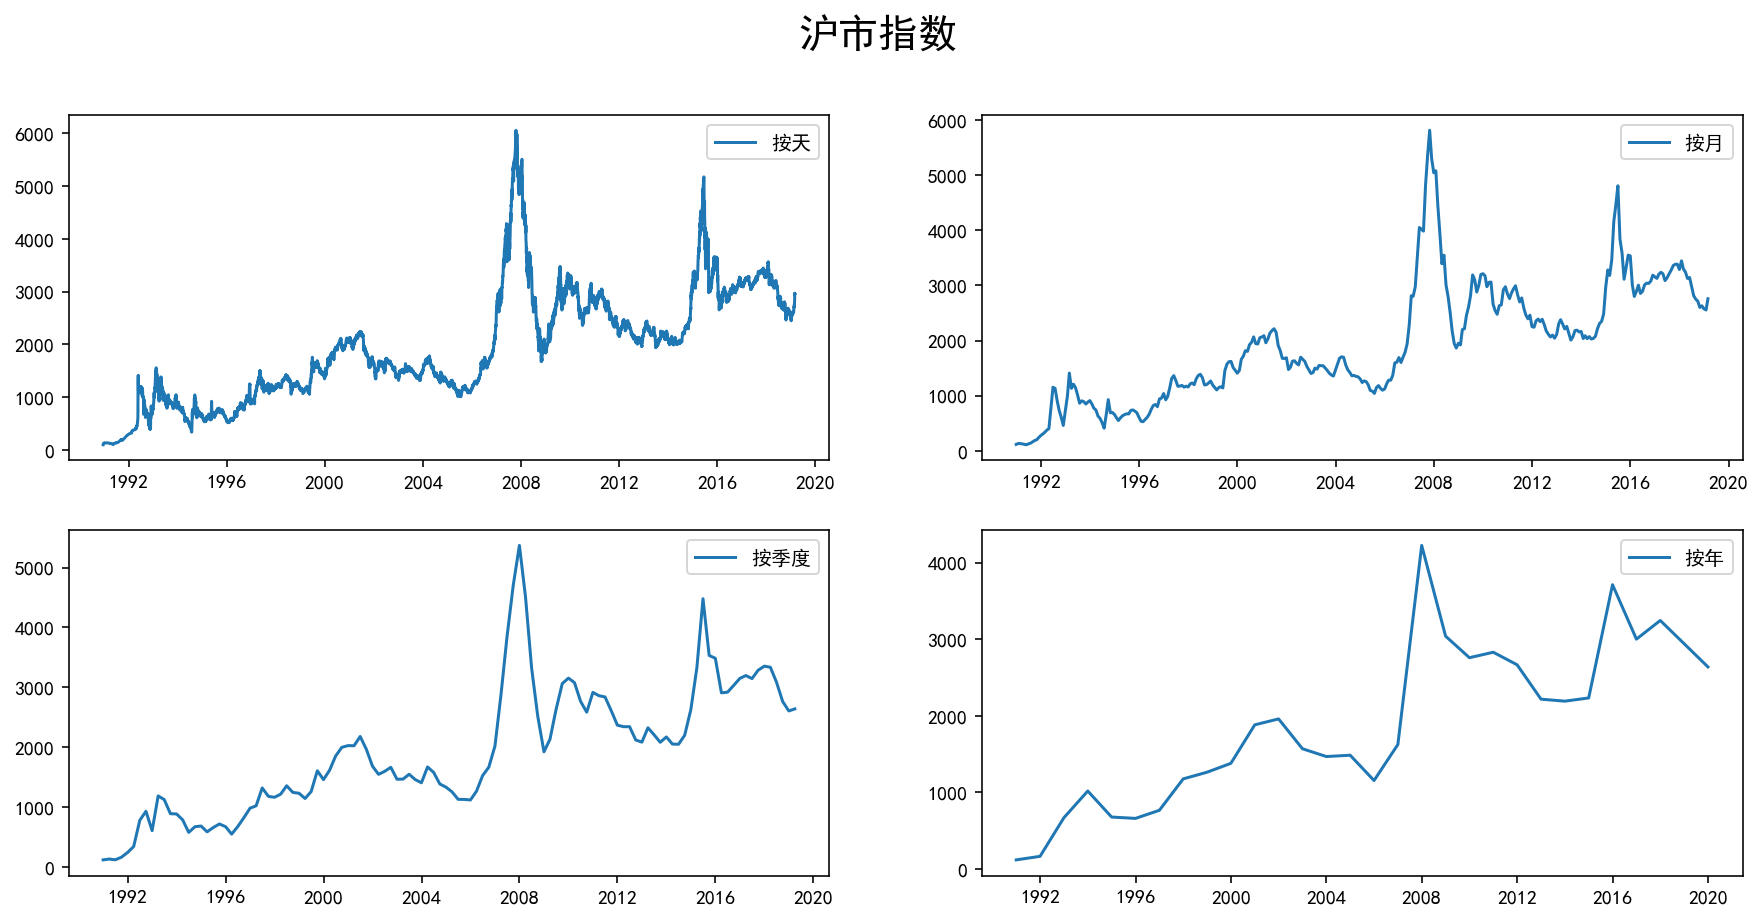

In [8]:
# 按照天，月，季度，年来显示比特币的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.suptitle('沪市指数', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='按年')
plt.legend()
plt.show()

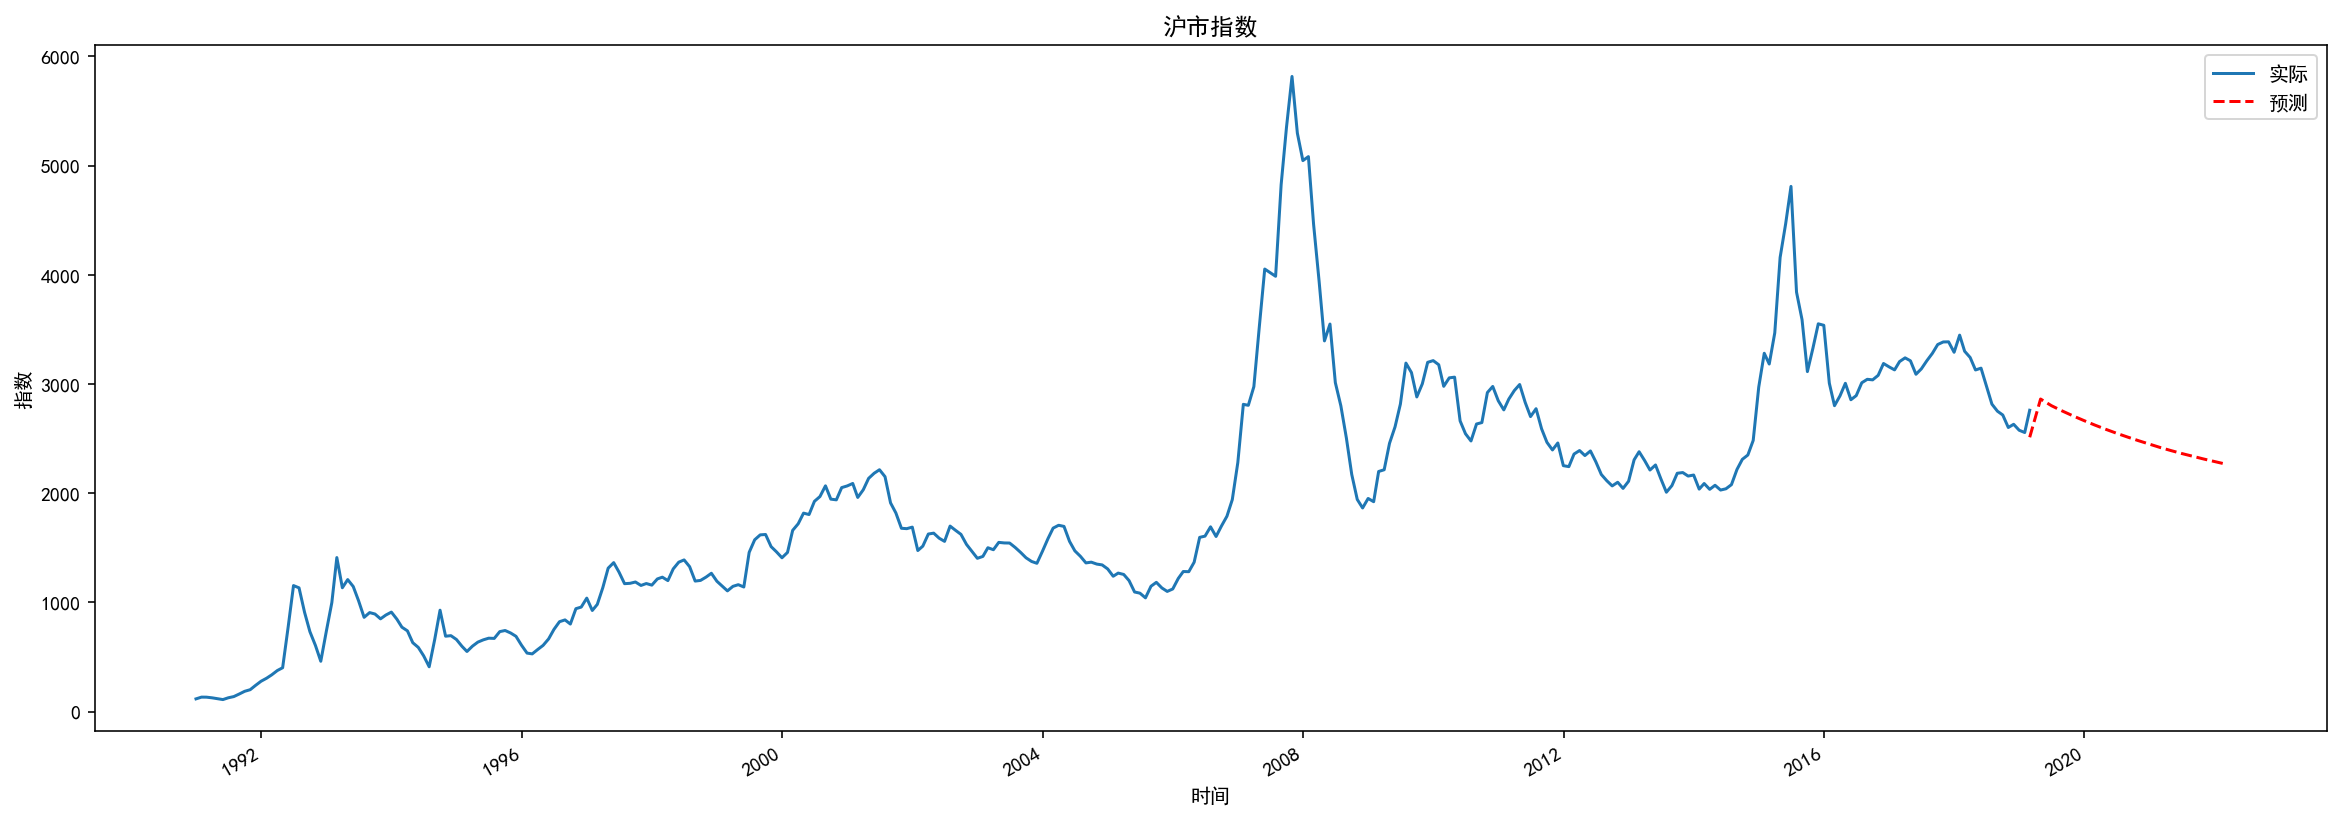

In [9]:
# 沪市预测
df_month2 = df_month[['Price']]
index = pd.date_range('2019-02-28','2022-03-31', freq='2M')
future = pd.DataFrame(index=index, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict('2019-02-28','2022-03-31') # 选择时间跨度，月份
# 沪市预测结果显示
plt.figure(figsize=(20,7))
df_month2.Price.plot(label='实际')
df_month2.forecast.plot(color='r', ls='--', label='预测')
plt.legend()
plt.title('沪市指数')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()